# Import required libraries

In [1]:
import os
import cv2
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import InceptionResNetV2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
warnings.filterwarnings('ignore')

# prepare_dataset

In [2]:
# Define the path to the training dataset
data_train = r"dataset"

# Create empty lists to hold image paths and their corresponding labels
filepaths = []
labels = []

# Loop over each label/class directory inside the training path
for label_name in os.listdir(data_train):
    class_folder = os.path.join(data_train, label_name)
    if os.path.isdir(class_folder):  # Ensure it's a folder
        # Loop over each image file in the class directory
        for filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, filename)
            
            # Append the image path and label to the respective lists
            filepaths.append(image_path)
            labels.append(label_name)

# Combine the file paths and labels into a Pandas DataFrame
data = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Output the DataFrame to verify the data structure
data

,filepaths,labels
0,dataset\no\aug_0_1000.jpg,no
1,dataset\no\aug_0_1013.jpg,no
2,dataset\no\aug_0_1015.jpg,no
3,dataset\no\aug_0_1017.jpg,no
4,dataset\no\aug_0_1020.jpg,no
...,...,...
2849,dataset\yes\aug_0_9959.jpg,yes
2850,dataset\yes\aug_0_9975.jpg,yes
2851,dataset\yes\aug_0_9976.jpg,yes
2852,dataset\yes\aug_0_9984.jpg,yes


In [3]:
print(len(filepaths))
print(len(labels))

2854
2854


In [4]:
print(labels[-1])

yes


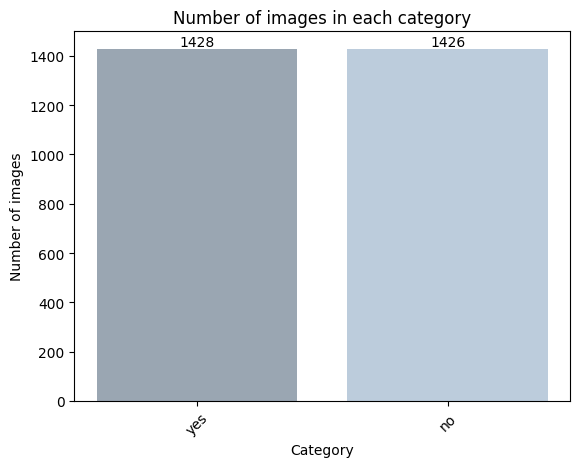

In [5]:
color = ['#9AA6B2','#BCCCDC','#D9EAFD','#F8FAFC']
label_counts = data['labels'].value_counts()
fig, ax = plt.subplots()
bars = ax.bar(label_counts.index, label_counts.values,color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()

In [6]:
print(np.unique(labels))

['no' 'yes']


# Split data into train, test, valid¶

In [7]:
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['labels'])

In [8]:
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels'])

In [9]:
print("Train size:", len(train_df))
print("Validation size:", len(valid_df))
print("Test size:", len(test_df))

Train size: 2283
Validation size: 285
Test size: 286


In [10]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data['labels']),
    y=data['labels']
)
class_weights_dict = dict(zip(np.unique(data['labels']), class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {'no': np.float64(1.0007012622720897), 'yes': np.float64(0.9992997198879552)}


# data_generators

In [11]:
# Define the data augmentation strategy for training and validation sets
datagen = ImageDataGenerator(
    rescale=1.0 / 255,           # Normalize pixel values to [0, 1]
    rotation_range=30,         # Random rotation in degrees
    width_shift_range=0.2,       # Random horizontal shift
    height_shift_range=0.2,      # Random vertical shift
    shear_range=0.2,             # Shear intensity
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'
)

# Apply augmentation to training dataset
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',           # Column with image paths
    y_col='labels',              # Column with class labels
    target_size=(224, 224),      # Resize images to 224x224
    batch_size=16,
    color_mode='rgb',            # Use RGB color space
    class_mode='categorical'     # For multi-class classification
)

# Apply same augmentation to validation dataset
validation_generator = datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=16,
    color_mode='rgb',
    class_mode='categorical'
)

# Define a separate generator for test data (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load test images using the test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=16,
    color_mode='rgb',
    shuffle=False,
    class_mode='categorical'
)

Found 2283 validated image filenames belonging to 2 classes.
Found 285 validated image filenames belonging to 2 classes.
Found 286 validated image filenames belonging to 2 classes.


# CNN_model_setup

In [ ]:
# Define CNN model
model_CNN  = Sequential([
    Conv2D(64, kernel_size= (3,3), activation='relu', input_shape=(224,224,3)), # Conv layer
    Conv2D(64, kernel_size= (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, kernel_size= (3,3), activation='relu'),
    Conv2D(128, kernel_size= (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(256, kernel_size= (3,3), activation='relu'),
    Conv2D(256, kernel_size= (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),                         # Flatten to 1D
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),                      # Reduce overfitting
    Dense(2, activation='softmax') ])
# Compile the model
model_CNN .compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Show model summary
model_CNN .summary()

# pre_trained_model_setup

In [13]:
# Load the base model with ImageNet weights, excluding the top classification layer
base_model = InceptionResNetV2(
    include_top=False,              # Exclude the fully-connected layers at the top
    weights="imagenet",             # Load pretrained weights from ImageNet
    input_shape=(224, 224, 3),      # Input image shape
    pooling="max" ,                   # Apply global max pooling after the convolutional base)       
    classes=1000, 
    input_tensor=None,
    classifier_activation="softmax",)

# Freeze base model layers first (for feature extraction phase)
base_model.trainable = False
# Define the final model architecture on top of the pre-trained base model
model_transfer = Sequential([
     base_model,                      # Frozen base model for feature extraction
    Flatten(),                       # Flatten output of the base model
    Dense(512, activation='relu'),   # Dense hidden layers for learning patterns
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')   # Output layer for 2-class classification
])

# Compile the model with Adamax optimizer and categorical crossentropy loss
model_transfer.compile(
    optimizer=Adamax(learning_rate=0.0001),  # Optimizer with learning rate
    loss='categorical_crossentropy',         # Suitable for one-hot encoded labels
    metrics=['accuracy']                     # Track accuracy during training
)

# Print the model summary to check architecture and parameters
model_transfer.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 1536)           │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,298,306 (210.95 MB)

 Trainable params: 961,570 (3.67 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

# Early stopping after 10 epochs without improvement in validation loss

In [14]:
# Set up EarlyStopping to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',             # Stop training when validation loss stops improving
    patience=10,                     # Wait for 10 epochs before stopping
    restore_best_weights=True       # Roll back to the best weights observed during training
)

# Save only the best performing model based on validation accuracy

In [ ]:
cnn_checkpoint = ModelCheckpoint(
    filepath='best_cnn_model.keras', # Save model in Keras format
    monitor='val_accuracy',          # Monitor validation accuracy
    save_best_only=True,             # Save only when the model improves
    mode='max',                      # Higher accuracy is better
    save_weights_only=False,         # Save full model (not just weights)
    verbose=1                        # Output message when model is saved
)

In [16]:
transfer_checkpoint = ModelCheckpoint(
    filepath='best_transfer_model.keras', # Save model in Keras format
    monitor='val_accuracy',               # Monitor validation accuracy
    save_best_only=True,                  # Save only when the model improves
    mode='max',                           # Higher accuracy is better
    save_weights_only=False,              # Save full model (not just weights)
    verbose=1                             # Output message when model is saved
)

# Reduce learning rate if validation loss plateaus for 10 epochs

In [17]:
# Reduce learning rate when the validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Monitor validation loss
    factor=0.1,             # Reduce LR by 10x when triggered
    patience=10,             # Number of epochs with no improvement before reduction
    verbose=1               # Log the LR change
)

# Train the model with callbacks for early stopping, checkpointing, and learning rate scheduling

In [ ]:
 # Train the model with training and validation data generators
# Includes early stopping, learning rate reduction, and best model checkpointing
history_CNN = model_CNN.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Set to a higher value (e.g. 10–50) for actual training
    callbacks=[
        early_stopping,
        cnn_checkpoint,
        reduce_lr
    ],
    class_weight=class_weights_dict,
    verbose=1
)

In [19]:
# Train the model with training and validation data generators
# Includes early stopping, learning rate reduction, and best model checkpointing
history_transfer = model_transfer.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Set to a higher value (e.g. 10–50) for actual training
    callbacks=[
        early_stopping,
        transfer_checkpoint,
        reduce_lr
    ],
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6691 - loss: 0.6148
Epoch 1: val_accuracy improved from None to 0.76842, saving model to best_transfer_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 568ms/step - accuracy: 0.7249 - loss: 0.5501 - val_accuracy: 0.7684 - val_loss: 0.4954 - learning_rate: 1.0000e-04
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8020 - loss: 0.4430
Epoch 2: val_accuracy did not improve from 0.76842
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 528ms/step - accuracy: 0.8134 - loss: 0.4263 - val_accuracy: 0.7579 - val_loss: 0.4619 - learning_rate: 1.0000e-04
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8172 - loss: 0.4067
Epoch 3: val_accuracy improved from 0.76842 to 0.82456, saving model to best_transfer_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 545ms/step - accuracy: 0.8340 - loss: 0.3853 - val_accuracy: 0.8246 - val_loss: 0.4335 - learning_rate: 1.0000e-04
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms

# plot_training_curves

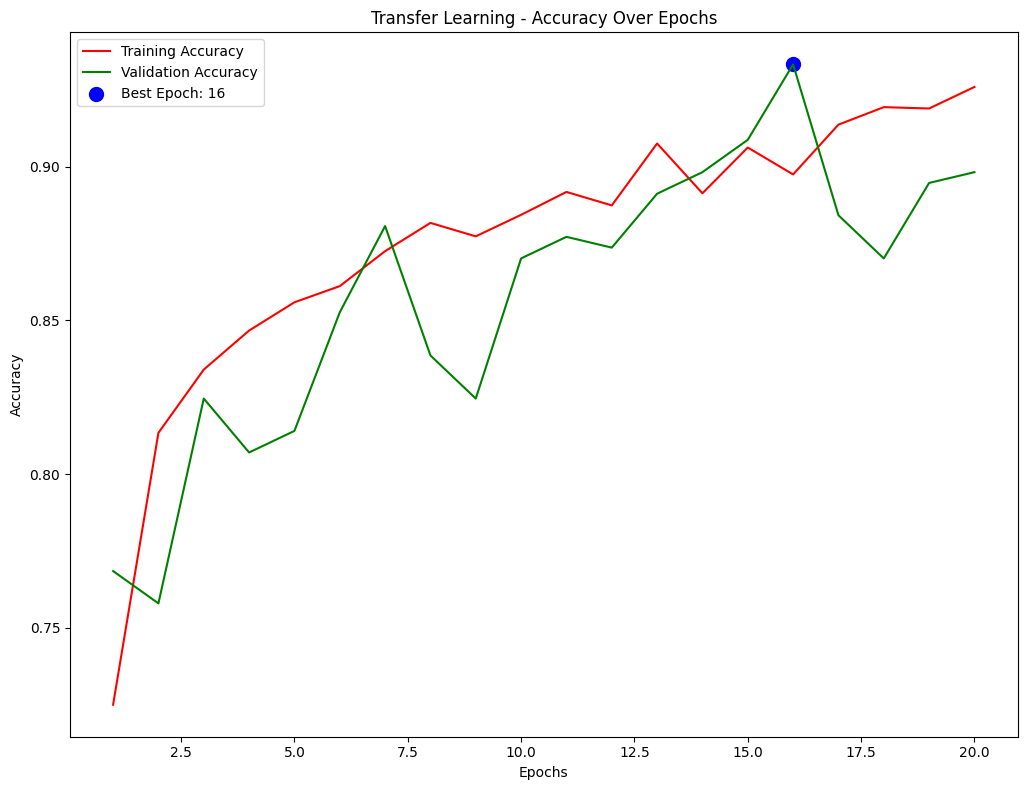

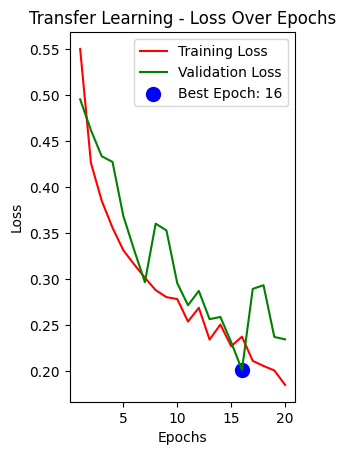

In [20]:
def plot_history(history, history_name="Model"):
    tr_acc = history['accuracy']         # Training accuracy
    val_acc = history['val_accuracy']    # Validation accuracy
    tr_loss = history['loss']            # Training loss
    val_loss = history['val_loss']       # Validation loss
    epochs = [i + 1 for i in range(len(tr_acc))]  # Epoch range

    plt.figure(figsize=(20, 8))
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(np.argmax(val_acc) + 1, max(val_acc), s=100, c='blue',
                label=f'Best Epoch: {np.argmax(val_acc) + 1}')
    plt.title(f"{history_name} - Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(np.argmin(val_loss) + 1, min(val_loss), s=100, c='blue',
                label=f'Best Epoch: {np.argmin(val_loss) + 1}')
    plt.title(f"{history_name} - Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

# ----- Plot for CNN -----
#plot_history(history_CNN.history, history_name="CNN")
# ----- Plot for Transfer Learning -----
plot_history(history_transfer.history, history_name="Transfer Learning")

# evaluate_models

In [ ]:
# Evaluate the model on the training dataset
train_score_CNN = model_CNN.evaluate(train_generator)

# Evaluate the model on the validation dataset
valid_score_CNN = model_CNN.evaluate(validation_generator)

# Evaluate the model on the external test dataset 
test_score_CNN = model_CNN.evaluate(test_generator)

# Print the evaluation results with formatting
print("=== CNN Training Performance ===")
print(f"Train CNN Loss: {train_score_CNN[0]:.4f}")
print(f"Train CNN Accuracy: {train_score_CNN[1]*100:.2f}%")
print('-' * 30)

print("=== CNN Validation Performance ===")
print(f"Validation CNN Loss: {valid_score_CNN[0]:.4f}")
print(f"Validation CNN Accuracy: {valid_score_CNN[1]*100:.2f}%")
print('-' * 30)

print("=== CNN Test Performance ===")
print(f"Test CNN Loss: {test_score_CNN[0]:.4f}")
print(f"Test CNN Accuracy: {test_score_CNN[1]*100:.2f}%")
print("=================== Transfer model ===================")
# Evaluate the model on the training dataset
train_score_transfer = model_transfer.evaluate(train_generator)

# Evaluate the model on the validation dataset
valid_score_transfer = model_transfer.evaluate(validation_generator)

# Evaluate the model on the external test dataset
test_score_transfer = model_transfer.evaluate(test_generator)

# Print the evaluation results with formatting
print("=== transfer Training Performance ===")
print(f"Train transfer Loss: {train_score_transfer[0]:.4f}")
print(f"Train transfer Accuracy: {train_score_transfer[1]*100:.2f}%")
print('-' * 30)

print("=== transfer Validation Performance ===")
print(f"Validation transfer Loss: {valid_score_transfer[0]:.4f}")
print(f"Validation transfer Accuracy: {valid_score_transfer[1]*100:.2f}%")
print('-' * 30)

print("=== transfer Test Performance ===")
print(f"Test transfer Loss: {test_score_transfer[0]:.4f}")
print(f"Test transfer Accuracy: {test_score_transfer[1]*100:.2f}%")

=================== Transfer model ===================
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 478ms/step - accuracy: 0.9172 - loss: 0.2069
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 485ms/step - accuracy: 0.9228 - loss: 0.2245
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - accuracy: 0.9476 - loss: 0.1624
=== transfer Training Performance ===
Train transfer Loss: 0.2069
Train transfer Accuracy: 91.72%
------------------------------
=== transfer Validation Performance ===
Validation transfer Loss: 0.2245
Validation transfer Accuracy: 92.28%
------------------------------
=== transfer Test Performance ===
Test transfer Loss: 0.1624
Test transfer Accuracy: 94.76%


# Confusion Matrix & Classification Report

=== Classification Report (Transfer Learning (InceptionResNetV2)) ===
              precision    recall  f1-score   support

          no       0.95      0.94      0.95       143
         yes       0.94      0.95      0.95       143

    accuracy                           0.95       286
   macro avg       0.95      0.95      0.95       286
weighted avg       0.95      0.95      0.95       286



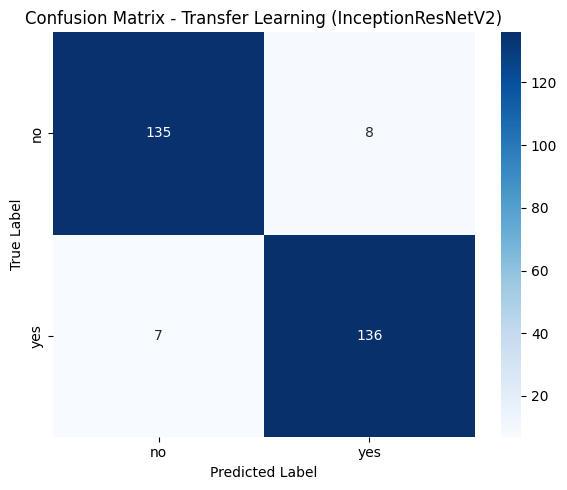

In [ ]:
def evaluate_predictions(model, model_name, test_generator):
    # Get true labels
    Y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())

    # Predict probabilities
    Y_pred_probs = model.predict(test_generator, verbose=0)
    Y_pred = np.argmax(Y_pred_probs, axis=1)

    # Classification report
    print(f"=== Classification Report ({model_name}) ===")
    print(classification_report(Y_true, Y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(Y_true, Y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Run models
#evaluate_predictions(model_CNN, "CNN", test_generator)
evaluate_predictions(model_transfer, "Transfer Learning (InceptionResNetV2)", test_generator)